In [9]:
%load_ext autoreload
%autoreload 2

import os,sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
# add project root dir to sys.path so that all packages can be found by python.
root_dir = os.path.dirname(os.path.realpath("__file__"))
sys.path.append(root_dir)
from data.musdb_loader import get_musdb_folds
from data.eval import create_method_store
from data.dataset import RawSeparationDataset
from museval.aggregate import MethodStore

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# DO NOT EXECUTE UNLESS YOU HAVE BASELINE AND ORACLE ESTIMATES IN JSON FILES!
def get_method_store(dataset, track_names=None):
    db_path = os.path.join(root_dir,'data', dataset)
    if (track_names is None):
        data = get_musdb_folds(db_path)
        path_list = data['test']
        track_names = list(map(lambda target_dict: os.path.basename(os.path.dirname(target_dict['mix'])), path_list))
    store = create_method_store(os.path.join(db_path,'estimates'), ['baseline', 'ibm','irm'], 'test')
    store.df = store.df[store.df.track.isin(track_names)]
    return store   

In [5]:
# DO NOT EXECUTE UNLESS YOU HAVE BASELINE AND ORACLE ESTIMATES IN JSON FILES!
musdb_store = get_method_store("musdb")
musdb_store.save("musdb_store")

Loading train set...
Loading test set...


Creating eval store: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.85s/it]


In [6]:
# DO NOT EXECUTE UNLESS YOU HAVE BASELINE AND ORACLE ESTIMATES IN JSON FILES!
musdb_extended_store = get_method_store("musdb_extended", list(map(str,list(range(736,921)))))
musdb_extended_store.save("musdb_ext_store")

Creating eval store: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.04s/it]


In [8]:
def _filter_df_col(df, col_name, col_values):
    if (col_values is not None):
        col_values = [col_values] if isinstance(col_values, str) else col_values
        df = df[df[col_name].isin(col_values)]
    if (len(df[col_name].unique()) == 1):
        df = df.drop(col_name, axis=1)
    return df

def get_method_metric_for_target(method_store, method, metric, target):
    # method = baseline, ibm, irm
    # metric = SDR, ISR, SIR, SAR
    # target = vocals, accompaniment, drums...
    
    # Get median scores for each track
    df = method_store.agg_frames_scores().reset_index(name='score').dropna()

    # Get lists of scores per method-metric-target
    df = df.groupby(['method','metric','target'])['score'].apply(list).reset_index(name='score')

    # filter by provided column values
    df = _filter_df_col( _filter_df_col( _filter_df_col(df, 'method', method),'metric', metric), 'target', target)
    return df['score'].values[0]


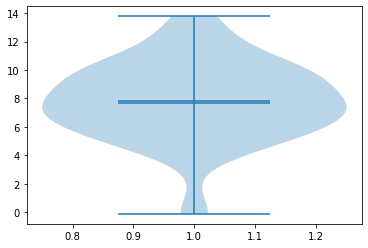

In [10]:
# This loads the metrics store from the notebook kernel and allows to get metrics for any method, metric and target.
musdb_store = MethodStore()
musdb_store.load("musdb_store")
vals = get_method_metric_for_target(musdb_store, 'ibm', 'SDR', 'vocals')
fig, ax = plt.subplots()
ax.violinplot(vals,showmeans=True, showextrema=True, showmedians=True);

In [5]:
def get_metrics(filepath, instruments=["vocals", "accompaniment"]):
    with open(filepath, "rb") as f:
        test_metrics = pickle.load(f)
    print(test_metrics)
    SDRs = {inst: [np.nanmean(song[inst]["SDR"]) for song in test_metrics] for inst in instruments}
    SIRs = {inst: [np.nanmean(song[inst]["SIR"]) for song in test_metrics] for inst in instruments}
    avg_SDRs = {inst: np.mean(SDRs[inst]) for inst in instruments}
    avg_SIRs = {inst: np.mean(SIRs[inst]) for inst in instruments}
    return SDRs, SIRs, avg_SDRs, avg_SIRs

def plot_metric(metric, metric_name, instruments=["vocals", "accompaniment"], axs=None):
    if not axs:
        fig, axs = plt.subplots(nrows=len(instruments), ncols=1, figsize=(10, 6))
    for i, instrument in enumerate(instruments):
        axs[i].violinplot(metric[instrument],
                     showmeans=True, showextrema=True, showmedians=True)
        axs[i].set_title(f"{metric_name} for {instrument}")

In [ ]:
SDRs, SIRs, avg_SDRs, avg_SIRs = get_metrics("results.pkl")

In [25]:
print(f"{avg_SDRs=}, {avg_SIRs=}")

avg_SDRs={'vocals': 2.7900325247439413, 'accompaniment': 7.700905718452066}, avg_SIRs={'vocals': 8.39428707334839, 'accompaniment': 18.718657266971196}


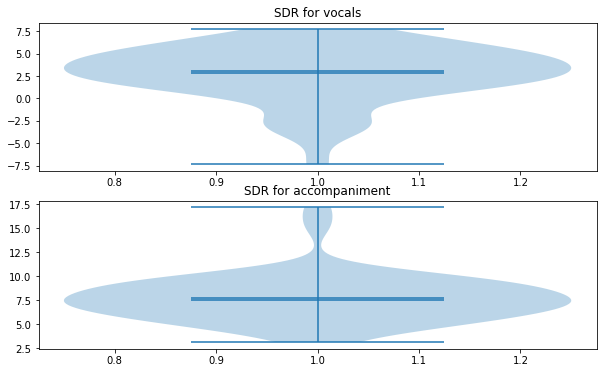

In [26]:
plot_metric(SDRs, "SDR")

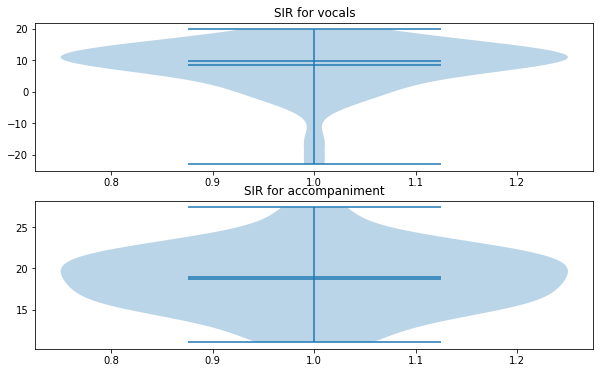

In [27]:
plot_metric(SIRs, "SIR")